# Practical assignment for lesson 1 (Week 2).
## Linear regression: retraining and regularization

In this task, we will use examples to see how linear models are retrained, analyze why this happens, and find out how to diagnose and control retraining.

In all cells where a comment with instructions is written, you need to write code that executes these instructions. The remaining cells with the code (without comments) just need to be executed. In addition, the task requires answering questions; the answers must be entered after the highlighted word "__Answer:__".

We remind you to look at the help of any method or function (find out what its arguments are and what it does) you can use the Shift+Tab combination. Pressing Tab after the name of the object and the dot allows you to see what methods and variables this object has.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

We will work with the dataset __"bikes_rent.csv"__, in which calendar information and weather conditions characterizing automated bike rental points, as well as the number of rentals on that day, are recorded by day. The latter we will predict; thus, we will solve the regression problem.

### Getting to know the data

Load the dataset using the __pandas.read_csv__ function into the __df__ variable. Print the first 5 lines to make sure that the data is read correctly:

In [3]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


For each rental day, the following features are known (as they were indicated in the data source):
* _season_: 1 - spring, 2 - summer, 3 - autumn, 4 - winter
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: from 1 to 12
* _holiday_: 0 - no holiday, 1 - there is a holiday
* _weekday_: from 0 to 6
* _workingday_: 0 - non-working day, 1 - working day
* _weathersit_: weather favorability rating from 1 (clear, clear day) to 4 (heavy rain, fog)
* _temp_: temperature in Celsius
* _atemp_: feels like temperature in Celsius
* _hum_: humidity
* _windspeed(mph)_: wind speed in miles per hour
* _windspeed(ms)_: wind speed in meters per second
* _cnt_: the number of rented bicycles (this is the target attribute, we will predict it)

So, we have real, binary and nominal (ordinal) features, and all of them can be worked with as real. You can also work with nominal features as with real ones, because the order is set on them. Let's look at the graphs, how the target attribute depends on the rest

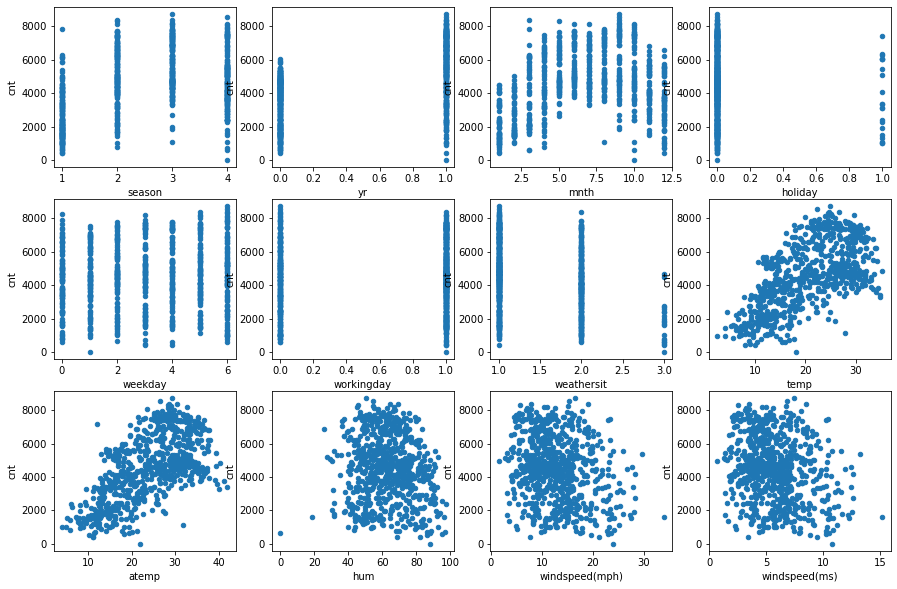

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__block 1. Answer the questions (each 0.5 points):__
1. What is the nature of the dependence of the number of rentals on the month? 
   * * answer: sinusoids, peak in summer, curvilinear dependence
1. Specify one or two features on which the number of rentals most likely depends linearly
   * answer: temp

Let's evaluate more strictly the level of linear dependence between the features and the target variable. A good measure of the linear relationship between two vectors is the Pearson correlation. In pandas, it can be calculated using two dataframe methods: car and car with. The df.corr method calculates the correlation matrix of all features from the dataframe. The df.car with method needs to submit another dataframe as an argument, and then it will calculate pairwise correlations between the features from df and this dataframe.

In [6]:
print('Correlation of DataFrame target column with others:')
df.iloc[:, :-1].corrwith(df.cnt)


Correlation of DataFrame target column with others:


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

There are features in the sample that correlate with the target, which means that the problem can be solved using linear methods.

The graphs show that some features are similar to each other. Therefore, let's also calculate correlations between real features.

In [7]:
print('Pairwise correlation of DataFrame columns:')
df[['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']].corr()


Pairwise correlation of DataFrame columns:


,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


On the diagonals, as expected, there are units. However, there are two more pairs of strongly correlated columns in the matrix: temp and temp (correlate by nature) and two windspeed (because it's just a translation of some units into others). Next, we will see that this fact negatively affects the training of the linear model.

Finally, let's look at the mean of the features (the mean method) to estimate the scale of the features and the fraction of 1 in binary features.

In [8]:
print('Mean values of features:')
df.mean()

Mean values of features:


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

The features have different scales, so for further work it is better for us to normalize the matrix of feature objects.

### Problem one: collinear features

So, in our data, one feature duplicates another, and there are two more very similar ones. Of course, we could have removed the duplicates right away, but let's see how the model training would have gone if we hadn't noticed this problem. 

To begin with, we will scale, or standardize the features: we will subtract its average from each feature and divide it by the standard deviation. This can be done using the scale method.

In addition, you need to mix the selection, this will be required for cross-validation.

In [9]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [10]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Let's train a linear regression on our data and look at the weights of the features.

In [11]:
from sklearn.linear_model import LinearRegression

In [13]:
lr_model = LinearRegression()
lr_model.fit(X, y)
print('LINEAR REGRESSION MODEL')
print('Weight coefficients:')
for item in zip(df_shuffled.columns[:-1], lr_model.coef_.round()):
    print (item)
print('\nIndependent term:')
print(lr_model.intercept_.round())


LINEAR REGRESSION MODEL
Weight coefficients:
('season', 571.0)
('yr', 1022.0)
('mnth', -141.0)
('holiday', -87.0)
('weekday', 137.0)
('workingday', 56.0)
('weathersit', -330.0)
('temp', 367.0)
('atemp', 586.0)
('hum', -146.0)
('windspeed(mph)', 12457744791410.0)
('windspeed(ms)', -12457744791608.0)

Independent term:
4504.0


We see that the weights for linearly dependent features modulo are significantly greater than for other features.

To understand why this happened, let's recall the analytical formula by which the weights of the linear model are calculated in the least squares method:

$w = (X^TX)^{-1} X^T y$.

If there are collinear (linearly dependent) columns in X, the matrix $X^TX$ becomes degenerate, and the formula ceases to be correct. The more dependent the features are, the smaller the determinant of this matrix and the worse the approximation of $Xw\approx y$. This situation is called the multicollinearity problem, you discussed it at the lecture.

This did not happen with a pair of temp-temp slightly less correlating variables, but in practice it is always worth carefully monitoring the coefficients for similar features.

_The solution to the multicollinearity problem is to regularize the linear model. The L1 or L2 norm of weights multiplied by the regularization coefficient $\alpha$ is added to the optimized functional. In the first case, the method is called Lasso, and in the second -Ridge. This is also described in more detail in the lecture.

Train Ridge and Lasso regressors with default parameters and make sure that the problem with the weights has been solved.

In [16]:
from sklearn.linear_model import Lasso, Ridge

In [17]:
ls_model = Lasso()
ls_model.fit(X, y)
print('LASSO MODEL')
print('Weight coefficients:')
for item in zip(df_shuffled.columns[:-1], ls_model.coef_.round()):
    print (item)
print('\nIndependent term:')
print(ls_model.intercept_.round())

LASSO MODEL
Weight coefficients:
('season', 560.0)
('yr', 1019.0)
('mnth', -129.0)
('holiday', -86.0)
('weekday', 137.0)
('workingday', 55.0)
('weathersit', -332.0)
('temp', 376.0)
('atemp', 577.0)
('hum', -144.0)
('windspeed(mph)', -197.0)
('windspeed(ms)', -0.0)

Independent term:
4504.0


In [19]:
rd_model = Ridge()
rd_model.fit(X, y)
print('RIDGE MODEL')
print('Weight coefficients:')
for item in zip(df_shuffled.columns[:-1], rd_model.coef_.round()):
    print (item)
print('\nIndependent term:')
print(rd_model.intercept_.round())

RIDGE MODEL
Weight coefficients:
('season', 563.0)
('yr', 1019.0)
('mnth', -132.0)
('holiday', -87.0)
('weekday', 138.0)
('workingday', 56.0)
('weathersit', -332.0)
('temp', 386.0)
('atemp', 566.0)
('hum', -145.0)
('windspeed(mph)', -99.0)
('windspeed(ms)', -99.0)

Independent term:
4504.0


### Problem two: uninformative features

Unlike L2-regularization, L1 resets weights for some features. An explanation of this fact is given in one of the lectures of the course.

Let's observe how the weights change with an increase in the regularization coefficient $\alpha$ (in the lecture, the coefficient with the regularizer could be denoted by another letter).

In [20]:
# Code 3.1 (1 point)
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # matrix of weights of size (number of regressors) x (number of features)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

#training Lasso model for different regressors
for index, item in enumerate(alphas):
    ls_model = Lasso(alpha=alphas[index])
    ls_model.fit(X, y)
    coefs_lasso[index] = ls_model.coef_

#training Ridge model for different regressors
for index, item in enumerate(alphas):
    rd_model = Ridge(alpha=alphas[index])
    rd_model.fit(X, y)
    coefs_ridge[index] = rd_model.coef_


We visualize the dynamics of weights with an increase in the regularization parameter:

Text(0.5, 1.0, 'Ridge')

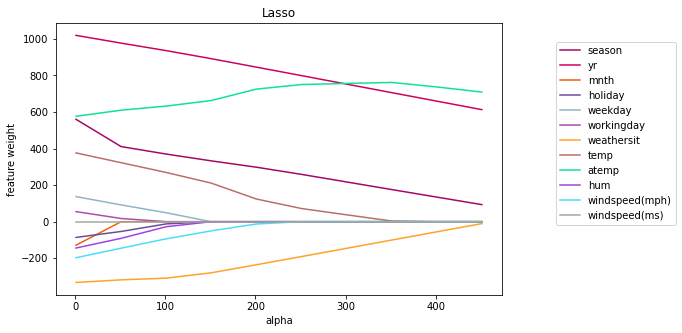

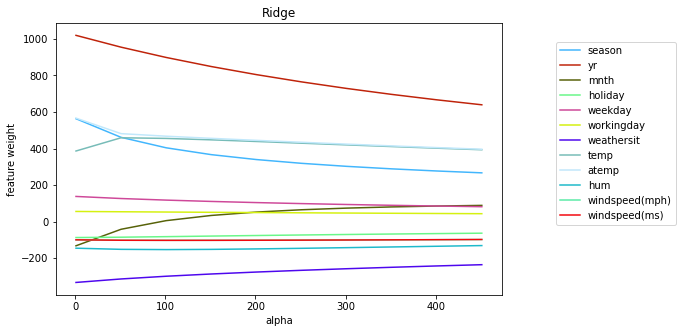

In [21]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Answers to the following questions can be given by looking at graphs or printing coefficients.

__block 2. Answer the questions (each 0.25 points)__:
1. Which regularizer (Ridge or Lasso) reduces weights more aggressively with the same alpha?
    * Answer: Lasso
1. What happens to Lasso scales if alpha is made very large? Explain why this is happening.
    * Answer: All coefficients are reset. Since the regularization coefficient determines the complexity of the model, the optimal solution for a large value is to make the coefficients equal to zero.
1. Is it possible to say that Lasso excludes one of the windspeed signs for any alpha value > 0? And Ridge? It is assumed that the regularizer excludes a feature if the coefficient with it is < 1e-3.
    * Answer: Yes, Lasso excludes. Ridge is not, the method makes the weights equal.
1. Which of the regularizers is suitable for the selection of uninformative features?
* Answer: Lasso

Next we will work with Lasso.

So, we see that when alpha changes, the model selects the coefficients of the features differently. We need to choose the best alpha.

To do this, firstly, we need a quality metric. We will use the optimized functionality of the least squares method itself as a metric, that is, Mean Square Error.

Secondly, you need to understand what data this metric is based on. You cannot select alpha by the MSE value on the training sample, because then we will not be able to estimate how the model will make predictions on new data for it. If we choose one split of the sample into training and test (this is called holdout), then we will tune in to specific "new" data, and we can retrain again. Therefore, we will make several splits of the sample, try different alpha values on each, and then average the MSE. It is most convenient to make such partitions by cross-validation, that is, divide the sample into K parts, or blocks, and each time take one of them as a test, and make a training sample from the remaining blocks.

Doing cross-validation for regression in sklearn is quite simple: there is a special regressor for this, __LassoCV__, which takes a list from alpha as input and calculates MSE for each of them on cross-validation. After training (set the cv=3 parameter), the regressor will contain the variable __mse\_path\___, a matrix of size len(alpha) x k, k = 3 (the number of blocks in cross-validation) containing the MSE values on the test for the corresponding runs. In addition, the selected value of the regularization parameter will be stored in the variable alpha\_, and in coef\_, traditionally, the trained weights corresponding to this alpha_ will be stored.

Note that the regressor can change the order in which it passes through the alphas; for matching with the MSE matrix, it is better to use the variable of the regressor alphas_.

In [22]:
from sklearn.linear_model import LassoCV

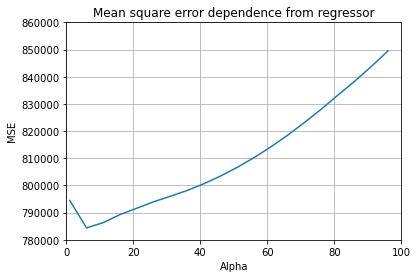

LASSO_CV MODEL

Alpha = 6

Weight coefficients:
('season', 532.0)
('yr', 1015.0)
('mnth', -100.0)
('holiday', -83.0)
('weekday', 133.0)
('workingday', 52.0)
('weathersit', -331.0)
('temp', 371.0)
('atemp', 581.0)
('hum', -140.0)
('windspeed(mph)', -192.0)
('windspeed(ms)', -0.0)

Independent term:
4504.0


In [24]:
# Code 3.2 (1 point)
# Train the LassoCV regressor on all regularization parameters from alpha
# Plot the _ averaged by MSE lines depending on alpha. 
# Output the selected alpha, as well as the "attribute-coefficient" pairs for the trained coefficient vector
alphas = np.arange(1, 100, 5)
lscv_model = LassoCV(alphas=alphas)
lscv_model.fit(X, y)

#Plot MSE(alpha)
plt.title('Mean square error dependence from regressor')
plt.plot(lscv_model.alphas_, np.mean(lscv_model.mse_path_, axis=1))
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.grid()
plt.axis([0, 100, 780000, 860000])
plt.show()

print('LASSO_CV MODEL')
#Best regressor value
print('\nAlpha = ' + str(lscv_model.alpha_))

#Weight coefficient for the optimal regressor
print('\nWeight coefficients:')
for item in zip(df_shuffled.columns[:-1], lscv_model.coef_.round()):
    print (item)
print('\nIndependent term:')
print(lscv_model.intercept_.round())

So, we have chosen some regularization parameter. Let's see which alpha we would choose if we sampled only once for training and test, that is, consider the MSE trajectories corresponding to individual sampling blocks.

Train/test split #1
Alpha = 6, MSE = 850613.93
Train/test split #2
Alpha = 1, MSE = 793023.25
Train/test split #3
Alpha = 6, MSE = 735686.04
Train/test split #4
Alpha = 1, MSE = 823369.27
Train/test split #5
Alpha = 1, MSE = 714094.66


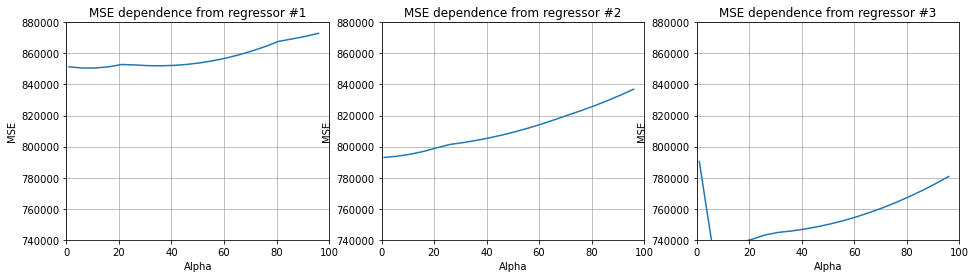

In [25]:
#Minimum MSE for every split
for index, item in enumerate(np.min(lscv_model.mse_path_, axis=0)):
    print('Train/test split #' + str(index+1))
    index_min = lscv_model.mse_path_[:,index].argmin(axis=0)
    print('Alpha = ' + str(lscv_model.alphas_[index_min]) + ', MSE = ' + str(round(item, 2)))

#Plot MSE(alpha) for train/test single split (cv = 3)
plt.figure(figsize=(16,4))
lscv_model.mse_path_
plot_number = 0
for index in range(3):
    plot_number += 1
    plt.subplot(1, 3, plot_number)
    plt.plot(lscv_model.alphas_, lscv_model.mse_path_[:, index])
    plt.title('MSE dependence from regressor #' + str(index+1))
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.grid()
    plt.axis([0, 100, 740000, 880000])

On each partition, the optimal alpha value has its own, and it corresponds to a larger MSE on other partitions. It turns out that we are tuning in to specific training and control samples. When choosing alpha on cross-validation, we choose something "average" that will give an acceptable metric value on different sample partitions.

Finally, as is customary in data analysis, let's interpret the results.

__block 3. Answer the questions (each 0.5 points):__
1. In the last trained model, select 4 features with the largest (positive) coefficients (and write them out), look at the visualizations of the cnt dependencies on these features that we drew in the "Getting to know the data" block. Is the increasing linear dependence of cnt on these features visible from the graphs? Is it logical to say (from common sense) that the greater the value of these signs, the more people will want to take bicycles? 
    * Answer: ('season', 532.0), ('yr', 1015.0), ('temp', 371.0), ('atemp', 581.0). The initial graphs show a linear relationship. The statement that the longer the year, the more people will take bicycles, for example, is not logical.
1. Select 3 features with the largest modulo negative coefficients (and write them out), look at the corresponding visualizations. Is the decreasing linear dependence visible? Is it logical to say that the greater the magnitude of these signs, the fewer people will want to take bicycles?
    * Answer: ('weathersit', -331.0), ('hum', -140.0), ('windspeed(mph)', -192.0). The decreasing dependence can be traced. It is logical for all features within their scope of definition.
1. Write down the signs with coefficients close to zero (< 1e-3). Why do you think the model excluded them from the model (look at the graphs again)? Is it true that they do not affect the demand for bicycles in any way?
    * Answer: ('windspeed(ms)', 0.0). This feature is linearly dependent.

### Conclusion
So, we looked at how you can monitor the adequacy of the linear model, how to select features and how to select the regularization coefficient correctly, if possible without tuning in to any specific portion of data. 

It is worth noting that using cross-validation, it is convenient to select only a small number of parameters (1, 2, maximum 3), because for each acceptable combination of them we have to train the model several times, and this is a time-consuming process, especially if you need to train on large amounts of data.